In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import copy

import sys
sys.path.append('../')

from angler import Simulation, Optimization
from angler.structures import ortho_port, two_port
from angler.plot import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 0.4e-1                 # grid size (L0)
NPML = [25, 25]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 10             # amplitude of modal source (A/L0^2?)

In [3]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
# max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [4]:
# geometric parameters
L1 = 6         # length waveguides in design region (L0)
L2 = 6          # width of box (L0)
H1 = 6          # height waveguides in design region (L0)
H2 = 6          # height of box (L0)
w = .3          # width of waveguides (L0)
l = 3           # length of waveguide from PML to box (L0)
spc = 3         # space between box and PML (L0)

Computed a domain with 350 grids in x and 350 grids in y
The simulation has 50 grids per free space wavelength


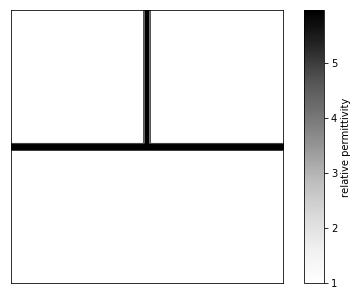

8
0
8


In [5]:
# define permittivity of three port system
eps_r, design_region = ortho_port(L1, L2, H1, H2, w, l, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

print(np.sum(simulation.eps_r[1,:]>1))
print(np.sum(simulation.eps_r[:,1]>1))
print(np.sum(simulation.eps_r[:,-1]>1))


In [19]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H1/2/dl), scale=source_amp)
simulation.setup_modes()

# left modal profile
right = Simulation(omega, eps_r, dl, NPML, 'Ez')
right.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(H1/2/dl))
right.setup_modes()
J_right = np.abs(right.src)

# top modal profile
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(np.sqrt(eps_m), 'y', [nx, -NPML[1]-int(l/2/dl)], int(L1/2/dl))
top.setup_modes()
J_top = np.abs(top.src)

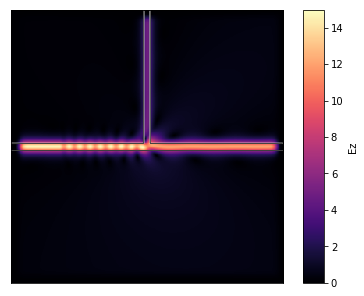

In [20]:
# set source and solve for electromagnetic fields
(_, _, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [21]:
# compute straight line simulation
eps_r_wg, _ = two_port(L1, H1, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(Ny/3), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg))*J_out)
J_out = J_out
print('computed a scale of {} in units of E^2 J_out'.format(SCALE))

J_right = J_right / SCALE
J_top = J_top / SCALE

computed a scale of 433.85858601592287 in units of E^2 J_out


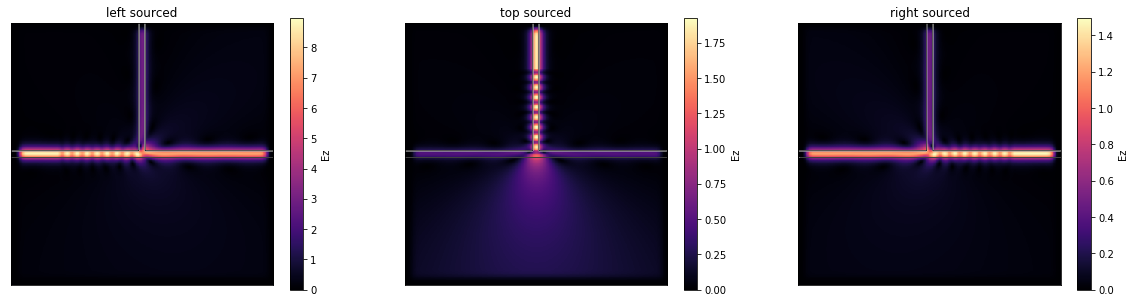

In [9]:
# set source and solve for electromagnetic fields
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

_ = simulation.solve_fields()
_ = top.solve_fields()
_ = right.solve_fields()

simulation.plt_abs(outline=True, cbar=True, ax=ax1)
top.plt_abs(outline=True, cbar=True, ax=ax2)
right.plt_abs(outline=True, cbar=True, ax=ax3)
ax1.set_title('left sourced')
ax2.set_title('top sourced')
ax3.set_title('right sourced')
plt.show()

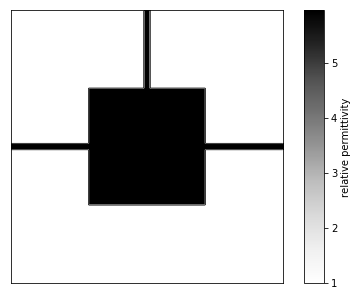

In [22]:
# changes design region. 'style' can be in {'full', 'empty', 'halfway', 'random'}
simulation.init_design_region(design_region, eps_m, style='full')
simulation.plt_eps()
plt.show()

In [23]:
# add nonlinearity
nl_region = copy.deepcopy(design_region)

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

In [24]:
# define objective function
import autograd.numpy as npa
from angler.objective import Objective, obj_arg
arg1 = obj_arg('ez', component='Ez', nl=False)
arg2 = obj_arg('ez_nl', component='Ez', nl=True)

def J(e, e_nl):
    linear_right =     1*npa.sum(npa.square(npa.abs(e))*J_right)
    linear_top =     -1*npa.sum(npa.square(npa.abs(e))*J_top)
    nonlinear_right = -1*npa.sum(npa.square(npa.abs(e_nl))*J_right)
    nonlinear_top =   1*npa.sum(npa.square(npa.abs(e_nl))*J_top)
    objfn = (linear_right + linear_top + nonlinear_right + nonlinear_top)/2
    return objfn

objective = Objective(J, arg_list=[arg1, arg2])

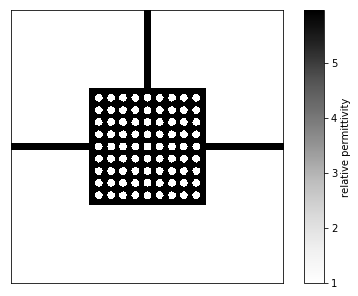

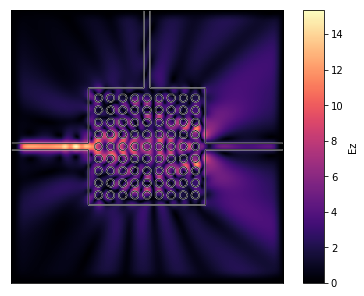

In [28]:
np.random.seed(2019)

# Add some holes
x = np.linspace(-2.5, 2.5, 9)
y = np.linspace(-2.5, 2.5, 9)
xs, ys = np.meshgrid(x, y)
# rs = 0.1 + np.random.rand(xs.shape[0], xs.shape[1])*0.2
rs = 0.2*np.ones(xs.shape)
simulation.apply_holes(xs, ys, rs)
# plot the permittivity distribution
simulation.plt_eps(outline=False)
plt.show()

# set source and solve for electromagnetic fields
(Hx, Hy, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [30]:
optimization = Optimization(objective=objective, simulation=simulation, design_region=design_region, eps_m=eps_m,
                            holes=True, holes_constraints={'fix_r':True})
new_eps_holes = optimization.run(method='adam', Nsteps=100, step_size = 0.01)

 ObjectiveFn: 4.61e-05 Iteration:  99/100 ETA:   0:00:36                       

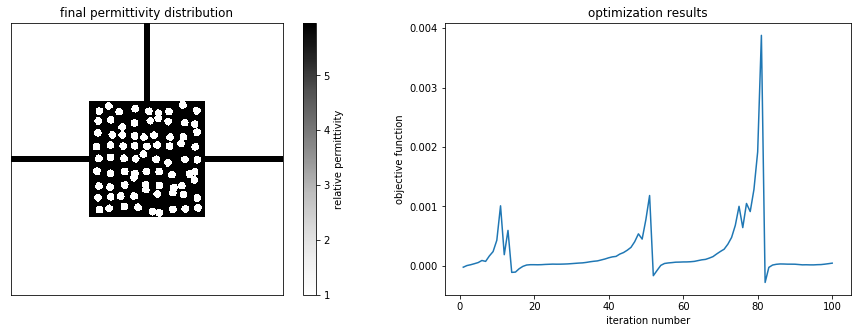

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')
optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

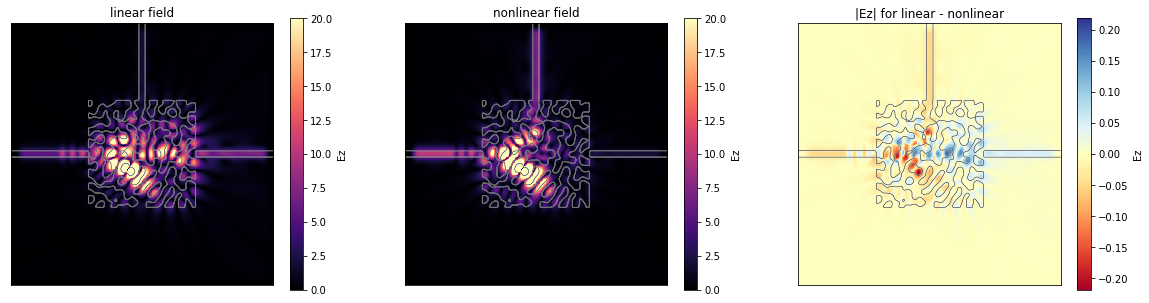

In [23]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1, vmax=20)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2, vmax=20, nl=True)
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

maximum refractive index shift of 0.0038495726142855347


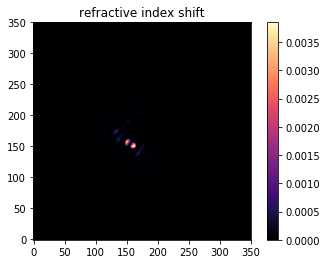

In [24]:
# compute the refractive index shift
index_shift = simulation.compute_index_shift()
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma', origin='lower')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

W_in = 0.056691256668203655
linear transmission (right)      = 0.8183
linear transmission (top)        = 0.0593
nonlinear transmission (right)   = 0.0611
nonlinear transmission (top)     = 0.8083


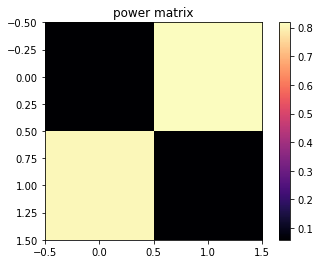

In [25]:
# input power
W_in = simulation.W_in
print("W_in = {}".format(W_in))

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_right_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(H1/2/dl))
W_top_lin  = simulation.flux_probe('y', [nx, -NPML[1]-int(l/2/dl)], int(H1/2/dl))

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_right_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(H1/2/dl), nl=True)
W_top_nl  = simulation.flux_probe('y', [nx, -NPML[1]-int(l/2/dl)], int(H1/2/dl), nl=True)


print('linear transmission (right)      = {:.4f}'.format(W_right_lin / W_in))
print('linear transmission (top)        = {:.4f}'.format(W_top_lin / W_in))
print('nonlinear transmission (right)   = {:.4f}'.format(W_right_nl / W_in))
print('nonlinear transmission (top)     = {:.4f}'.format(W_top_nl / W_in))

S = [[W_top_lin / W_in, W_right_lin / W_in],
     [W_top_nl / W_in,  W_right_nl / W_in]]
plt.imshow(S, cmap='magma')
plt.colorbar()
plt.title('power matrix')
plt.show()